# Numerical method to do the reproduction

Reminder: use Ctrl+/ to add/cancel comment for whole cell

### import stuff

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from tqdm import tqdm
from scipy.constants import k as k_B, e
from math import isclose

### Parameters define

In [3]:
# Tight-binding model parameters
a = 3.18
t1 = 146e-3
t2 = -0.40 * t1
t3 = 0.25 * t1
mu = 0

# Physical constants in convenient units
mu_B_eVT = 5.7883818012e-5  # Bohr magneton in eV/T
k_B_eV = k_B / e           # Boltzmann constant in eV/K

# Zeeman-type spin-splitting parameters (initial values)
alpha = 0
beta = 0

# Define the critical temperature and convert it to units of eV
Tc_K = 6.5
Tc_eV = k_B_eV * Tc_K

### Core code

This is the Fermi shell approxi version code. Basiclly give up sum over all k space version.

In [4]:
# energy dispersion, corresponding to H_{kin} term
def eps_Mo(kx, ky, mu):
    return (2*t1*(np.cos(ky*a) + 2*np.cos(np.sqrt(3)/2*kx*a)*np.cos(0.5*ky*a))
            +2*t2*(np.cos(np.sqrt(3)*kx*a) + 2*np.cos(np.sqrt(3)/2*kx*a)*np.cos(1.5*ky*a))
            +2*t3*(np.cos(2*ky*a) + 2*np.cos(np.sqrt(3)*kx*a)*np.cos(ky*a))-mu)

# g_z(k) for Zeeman-type SOI
def core_g(kx, ky):
    # sin(ky a) - 2 cos(√3/2 kx a) sin(ky a/2)
    return np.sin(ky*a) - 2*np.cos(np.sqrt(3)/2*kx*a)*np.sin(0.5*ky*a)

def f_k(kx, ky):
    # f(k) = | core_g(k) |
    return np.abs(core_g(kx, ky))

def F_k(kx, ky, fK, beta):
    # F(k) = beta * tanh[ f(K) - f(k) ] - 1
    return beta * np.tanh(fK - f_k(kx, ky)) - 1.0

def gzz(kx, ky, fK, beta):
    return F_k(kx, ky, fK, beta) * core_g(kx, ky)

# g_R(k) for Rashba-type SOI
def gR_core(kx, ky):
    gx_core = -np.sin(ky*a) - np.cos(np.sqrt(3)/2*kx*a)*np.sin(0.5*ky*a)
    gy_core = np.sqrt(3) * np.sin(np.sqrt(3)/2*kx*a)*np.cos(0.5*ky*a)
    return gx_core, gy_core

def gR_vec(kx, ky, fK, beta):
    Fk = F_k(kx, ky, fK, beta)
    gx_core, gy_core = gR_core(kx, ky)
    return Fk * gx_core, Fk * gy_core

def gR_mag(kx, ky, fK, beta):
    gx, gy = gR_vec(kx, ky, fK, beta)
    return np.sqrt(gx*gx + gy*gy)

# High symmetry points
Gamma = np.array([0.0, 0.0])
K = np.array([0.0, 4*np.pi/(3*a)])
M = np.array([np.pi/(np.sqrt(3)*a), np.pi/a])

# Path, Γ←K (neg s) and K→M (pos s), near K
def path_around_K(smax=0.2, N=501):
    v_GK = K - Gamma
    v_KM = M - K
    L_GK = np.linalg.norm(v_GK)
    L_KM = np.linalg.norm(v_KM)

    u1 = np.linspace(1 - smax/L_GK, 1.0, N)   # Γ→K near K
    u2 = np.linspace(0.0, smax/L_KM, N)       # K→M near K

    k_GK = Gamma + u1[:,None]*v_GK
    k_KM = K     + u2[:,None]*v_KM

    s_GK = -(1.0 - u1) * L_GK    # [-smax, 0]
    s_KM =  (u2      ) * L_KM    # [ 0, +smax]

    kx = np.concatenate([k_GK[:,0], k_KM[:,0]])
    ky = np.concatenate([k_GK[:,1], k_KM[:,1]])
    s  = np.concatenate([s_GK,       s_KM])

    return kx, ky, s

kx, ky, s = path_around_K(smax=0.2, N=501)

# Align to E_F
mu_guess = 0.0
E_K_raw  = eps_Mo(0, 4*np.pi/(3*a), mu_guess)     # Energy at K point with initial mu_guess
E_F      = E_K_raw + 0.15
E = lambda kx,ky: eps_Mo(kx,ky,mu_guess)-E_F


kx_l, ky_l, s_l = path_around_K(0.2, 301)
mask_R = s_l >= 0
kF_idx = np.argmin(np.abs(E(kx_l[mask_R], ky_l[mask_R])))
kF_kx, kF_ky = kx_l[mask_R][kF_idx], ky_l[mask_R][kF_idx]

# alpha and beta calibration
fK    = f_k(K[0], K[1])
coreK = abs(core_g(K[0], K[1]))
alpha = (3e-3) / (2.0*max(coreK,1e-18))

def beta_from_target(target_meV):
    betas = np.linspace(0.5, 200.0, 2001)
    spls  = np.array([2*alpha*abs(gzz(kF_kx, kF_ky, fK, b)) for b in betas])
    return float(betas[np.argmin(np.abs(spls - target_meV*1e-3))])

# ------------------------ Fermi shell ------------------------
# K and -K patches in k-space
def k_patch(center, rad, Nk):
    qx = np.linspace(-rad, rad, Nk)
    qy = np.linspace(-rad, rad, Nk)
    Qx, Qy = np.meshgrid(qx, qy, indexing='xy')
    mask = (Qx**2 + Qy**2 <= rad**2)
    kx = center[0] + Qx[mask]
    ky = center[1] + Qy[mask]
    return kx, ky

# Build Fermi surface shell samples around K and -K
def build_FS_shell(mu_guess, EF, rad, Nk, n_keep):
    kxK,  kyK  = k_patch(K,   rad, Nk)
    kxKm, kyKm = k_patch(-K,  rad, Nk)
    xiK  = eps_Mo(kxK,  kyK,  mu_guess) - EF
    xiKm = eps_Mo(kxKm, kyKm, mu_guess) - EF
    idxK  = np.argsort(np.abs(xiK))[:n_keep]
    idxKm = np.argsort(np.abs(xiKm))[:n_keep]
    return (kxK[idxK], kyK[idxK]), (kxKm[idxKm], kyKm[idxKm])

# ------------------------ Susceptibility calculation ------------------------
# 2x2 identity and Pauli matrices
I2 = np.eye(2, dtype=complex)
sx = np.array([[0, 1],[1, 0]], dtype=complex)
sz = np.array([[1, 0],[0,-1]], dtype=complex)

# k grid setup
Nk = 121
kx_vals = np.linspace(-np.pi/a, np.pi/a, Nk)
ky_vals = np.linspace(-np.pi/a, np.pi/a, Nk)
# Precompute k-grid and dispersion once
kx_grid, ky_grid = np.meshgrid(kx_vals, ky_vals, indexing='xy')
eps_grid_global = eps_Mo(kx_grid, ky_grid, mu)

# Encapsulated as g_z(kx, ky) without additional parameters
gz_func = lambda kx, ky: gzz(kx, ky, fK, beta)

# calculate χ using the formula with vectorization over k-grid
def chi_singlet_vectorized(T, H, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw):

    # K-point k-grid
    kxK,  kyK  = kK

    # Energy at k
    EK   = eps_Mo(kxK,  kyK,  mu_guess) - EF

    # Zeeman-type component DeltaZ at k
    DeltaZ_K  = alpha_Z * gz_func(kxK,  kyK)

    # Rashba components g_Rx, g_Ry at k
    gRxK, gRyK   = gR_func(kxK,  kyK)

    # Matsubara frequencies
    wn = (2*np.arange(Nw)+1) * np.pi * k_B_eV * T

    # use [:, None] and [None, :] to vectorize over k and omega_n. (broadcasting)
    A1   = 1j*wn[:,None] - EK[None,:]    # G(k, i omega_n)
    
    # Using symmetry properties: eps(-k) = eps(k)
    A2  = -1j*wn[:,None] - EK[None,:]   # G(-k, -i omega_n)

    # 3 components of effective field B at K
    Bx  = (-mu_B_eVT * H) + alpha_R * gRxK[None,:]      # B_x = -mu_B*H + alpha_R * g_Rx(k)
    By  = (alpha_R * gRyK)[None,:]                      # B_y = alpha_R * g_Ry(k)
    Bz  = (-DeltaZ_K)[None,:]                           # B_z = -Delta_Z(k)

    # 3 components of effective field B at -k (using symmetry properties)
    # Bx2: gRx(-k) = -gRx(k) (odd function)
    Bx2 = (-mu_B_eVT * H) - alpha_R * gRxK[None,:]
    # By2: gRy(-k) = gRy(k) (even function)
    By2 = (alpha_R * gRyK)[None,:]
    # Bz2: DeltaZ(-k) = -DeltaZ(k) (odd function)
    Bz2 = -(-DeltaZ_K)[None,:]

    # 2×2 green's function elements G(k, i omega_n)
    denominator1  = (A1*A1  - Bx*Bx  - By*By  - Bz*Bz)
    Guu    = (A1 - Bz)/denominator1
    Gdd    = (A1 + Bz)/denominator1
    Gud    = (Bx - 1j*By)/denominator1
    Gdu    = (Bx + 1j*By)/denominator1

    # 2×2 green's function elements G(-k, -i omega_n)
    denominator2 = (A2*A2 - Bx2*Bx2 - By2*By2 - Bz2*Bz2)
    Guu_m  = (A2 - Bz2)/denominator2
    Gdd_m  = (A2 + Bz2)/denominator2
    Gud_m  = (Bx2 - 1j*By2)/denominator2
    Gdu_m  = (Bx2 + 1j*By2)/denominator2

    # singlet pairing susceptibility
    term = Guu*Gdd_m - Gdu*Gud_m
    chi  = (k_B_eV*T) * np.real(term.sum()) / kxK.size
    return float(chi)

# find V from Tc at H=0
def determine_V(Tc, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw):
    chi_Tc0 = chi_singlet_vectorized(Tc, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
    return 1.0 / chi_Tc0




### Find $H_c2(T)$ for 13meV with multi Rashba

In [9]:
# ------------------------ Find Hc2 ----------------------------
# Find Hc2 at given T using bisection method searching in [0, Hmax]
def find_Hc2(T, V, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw, Hmax=100.0):
    if V*chi_singlet_vectorized(T, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw) < 1.0:
        return 0.0
    lo, hi = 0.0, Hmax
    for _ in range(24):
        mid = 0.5*(lo+hi)
        v   = V*chi_singlet_vectorized(T, mid, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
        if v >= 1.0: lo = mid
        else:        hi = mid
    return 0.5*(lo+hi)

# ------------------------ Curves with multiple eta ----------------------------
# Delta = 13 meV with varity η = <S_R>/<S_Z>

FSrad = 0.4
n_keep_value=1200
Nk_value=91

kK, _ = build_FS_shell(mu_guess, E_F, FSrad, Nk_value, n_keep_value)
print("FS sample per valley:", kK[0].size)

Tc = 6.5
Ts = np.linspace(0.1, 7.0, 100)
Nw = 800


# target spin splitting fixed at 13 meV
targ = 13.0
beta = beta_from_target(targ)

# g-vectors
gz_fun = lambda kx, ky, fK=fK, b=beta: gzz(kx, ky, fK, b)
gR_fun = lambda kx, ky, fK=fK, b=beta: gR_vec(kx, ky, fK, b)

# set of η values
# eta_list = [0.00, 0.02, 0.06, 0.10]
eta_list = [0.02, 0.1, 0.3, 0.5]

plt.figure(figsize=(6,4.6))
for eta in eta_list:
    alpha_R = eta * alpha  

    # use Tc at H=0 to calibrate V
    V = determine_V(Tc, alpha, alpha_R, gz_fun, gR_fun, kK, mu_guess, E_F, Nw)

    # progress bar
    Hs = [find_Hc2(T, V, alpha, alpha_R, gz_fun, gR_fun, kK, mu_guess, E_F,
                   Nw, Hmax=100.0)
          for T in tqdm(Ts, desc=f'Hc2 eta={eta:.2g}')]

    plt.plot(Ts, Hs, lw=2.2, label=rf'$\eta={eta:.2g}$')

plt.xlabel('T (K)')
plt.ylabel(r'$\mu_0 H_{c2}$ (T)')
plt.xlim(0, 7.0); plt.ylim(0, 80)
plt.grid(True, ls=':')
plt.legend(title=r'$\eta=\langle S_R\rangle/\langle S_Z\rangle$')
plt.tight_layout()
plt.title(r'$H_{c2}(T)$ with fixed $\Delta(k_F)=13$ meV and varying $\eta$')
plt.show()


FS sample per valley: 1200


Hc2 eta=0.02:  45%|████▌     | 45/100 [01:52<02:17,  2.51s/it]


KeyboardInterrupt: 

<Figure size 600x460 with 0 Axes>

### $H_{c2}(\mu)$

In [9]:
# ---------- 1. Fermi shell & V 的标定（在参考 μ0 处） ----------

# 费米面壳参数（自己按需要调）
rad_FS   = 0.15       # k 空间圆盘半径
Nk_FS    = 101        # k 网格
n_keep   = 400        # 每个 valley 选取的最近 FS 点数
Nw       = 512        # Matsubara 频率数量

# 参考化学势，用来标定 V
mu_guess = 0.0
mu0 = mu_guess        # 你现在的代码就是用 mu_guess 来对齐 K 点

# 构建参考 μ0 下的 K 处 Fermi shell
(kxK0, kyK0), (kxKm0, kyKm0) = build_FS_shell(mu0, E_F, rad_FS, Nk_FS, n_keep)
kK0 = (kxK0, kyK0)

# Rashba g 函数
gR_func = lambda kx, ky: gR_vec(kx, ky, fK, beta)

# 这里假设 alpha_Z, alpha_R 已经在你别的 cell 里面定义好
# 如果没有，可以先简单设，例如：
# alpha_Z = alpha
# alpha_R = 0.1 * alpha

# 由 Tc(K) 标定 V（注意 Tc_eV 已在你给的代码里算好了）
V = determine_V(Tc_eV, alpha, alpha_R, gz_func, gR_func, kK0, mu0, E_F, Nw)

# ---------- 2. 单个 μ 上临界场 Hc2(μ) 的二分法 ----------

def find_Hc2_single_mu(mu_val,
                       T_fixed,
                       V,
                       alpha_Z,
                       alpha_R,
                       rad_FS,
                       Nk_FS,
                       n_keep,
                       Nw,
                       Hmin=0.0,
                       Hmax=40.0,
                       tol=1e-3,
                       max_iter=60):
    """
    对给定 μ，在固定温度 T_fixed 下，用二分法求解 V * χ(T_fixed, H) = 1 的 Hc2.
    """

    # 该 μ 下重建 K 处的 Fermi shell
    (kxK, kyK), (kxKm, kyKm) = build_FS_shell(mu_val, E_F, rad_FS, Nk_FS, n_keep)
    kK = (kxK, kyK)

    # 方便传进 χ 的函数
    gR_func_local = lambda kx, ky: gR_vec(kx, ky, fK, beta)

    # 先检查两端点是否夹住解
    chi_min = chi_singlet_vectorized(T_fixed, Hmin, alpha_Z, alpha_R,
                                     gz_func, gR_func_local, kK,
                                     mu_val, E_F, Nw)
    chi_max = chi_singlet_vectorized(T_fixed, Hmax, alpha_Z, alpha_R,
                                     gz_func, gR_func_local, kK,
                                     mu_val, E_F, Nw)

    # 如果在很小场就已经 V*χ < 1，说明此 μ 下本来就不超导
    if V * chi_min < 1.0:
        return 0.0

    # 如果到 Hmax 仍然 V*χ > 1，说明需要更大上限
    if V * chi_max > 1.0:
        return np.nan  # 提示需要把 Hmax 再调大

    # 二分法求解 V * χ(T_fixed, H) = 1
    left, right = Hmin, Hmax
    for _ in range(max_iter):
        mid = 0.5 * (left + right)
        chi_mid = chi_singlet_vectorized(T_fixed, mid, alpha_Z, alpha_R,
                                         gz_func, gR_func_local, kK,
                                         mu_val, E_F, Nw)
        if V * chi_mid > 1.0:
            left = mid   # 还在超导区，临界场在右边
        else:
            right = mid  # 已经变成常态，临界场在左边

        if right - left < tol:
            break

    return 0.5 * (left + right)

# ---------- 3. 扫描 μ，画 Hc2(μ) ----------

# 扫描区间和步数（单位 eV，根据你想要的范围自己改）
mu_min = -0.05
mu_max =  0.05
N_mu   =  25

mu_list  = np.linspace(mu_min, mu_max, N_mu)
Hc2_list = []

# 固定一个温度（低于 Tc），比如 2 K
T_fixed = 2.0  # K

for mu_val in tqdm(mu_list):
    Hc2_val = find_Hc2_single_mu(mu_val,
                                 T_fixed,
                                 V,
                                 alpha,
                                 alpha_R,
                                 rad_FS,
                                 Nk_FS,
                                 n_keep,
                                 Nw,
                                 Hmin=0.0,
                                 Hmax=40.0)
    Hc2_list.append(Hc2_val)

Hc2_list = np.array(Hc2_list)

plt.figure(figsize=(6,4))
plt.plot(mu_list, Hc2_list, marker='o')
plt.xlabel(r'$\mu$ (eV)')
plt.ylabel(r'$H_{c2}$ (T)')
plt.title(r'$H_{c2}$ vs $\mu$ at $T = %.1f\,\mathrm{K}$' % T_fixed)
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'alpha_R' is not defined

### Find $T_c(\mu)$ for fix $V$ and magnetic field = 0

Calibrating fixed V...
FS sample per valley (for V calibration): 5000
Building FS shell at calibration point EF_center = -0.7479 eV
FS sample per valley (for V calibration): 5000
Starting Tc(mu) calculation for eta list: [0.02, 0.1, 0.3, 0.5]

--- Processing eta = 0.02 ---
  Calibrated V = 0.044707 for eta = 0.02


  Scanning E_F (eta=0.02): 100%|██████████| 51/51 [02:41<00:00,  3.16s/it]



--- Processing eta = 0.10 ---
  Calibrated V = 0.044711 for eta = 0.10


  Scanning E_F (eta=0.10): 100%|██████████| 51/51 [02:39<00:00,  3.14s/it]



--- Processing eta = 0.30 ---
  Calibrated V = 0.044746 for eta = 0.30


  Scanning E_F (eta=0.30): 100%|██████████| 51/51 [02:39<00:00,  3.14s/it]



--- Processing eta = 0.50 ---
  Calibrated V = 0.044816 for eta = 0.50


  Scanning E_F (eta=0.50): 100%|██████████| 51/51 [02:39<00:00,  3.13s/it]


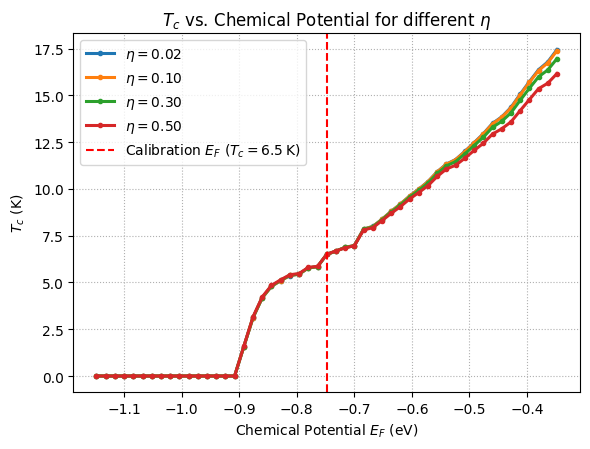

In [ ]:
# ------------------------ Find Tc ----------------------------
# Find Tc at given H=0 using bisection method searching in [Tmin, Tmax]
def find_Tc(V, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw, Tmax=20.0, Tmin=0.01):
    # Check if it's superconducting at all (at T_min)
    # H=0.0
    chi_minT = chi_singlet_vectorized(Tmin, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
    if V * chi_minT < 1.0:
        return 0.0  # Not superconducting

    # Check if it's normal at Tmax
    # H=0.0
    chi_maxT = chi_singlet_vectorized(Tmax, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
    if V * chi_maxT > 1.0:
        print(f"Warning: Still superconducting at Tmax={Tmax}K for EF={EF}. Increase Tmax.")
        return Tmax

    lo, hi = Tmin, Tmax
    for _ in range(24): # Bisection search
        mid = 0.5 * (lo + hi)
        # H=0.0
        v = V * chi_singlet_vectorized(mid, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
        if v >= 1.0:  # Superconducting phase (T < Tc)
            lo = mid
        else:         # Normal phase (T > Tc)
            hi = mid
    return 0.5 * (lo + hi)


# ------------------------ Calculate Tc(mu) for fixed V ------------------------
# We use the parameters from the first curve (target_meV = 13.0) to fix V
print("Calibrating fixed V...")
target_meV_for_V = 13.0
beta_for_V = beta_from_target(target_meV_for_V)

gz_fun_fixed = lambda kx, ky, fK=fK, b=beta_for_V: gzz(kx, ky, fK, b)
gR_fun_fixed = lambda kx, ky, fK=fK, b=beta_for_V: gR_vec(kx, ky, fK, b)

Tc_initial = 6.5        # K
Nw = 1600                # Matsubara frequencies
n_keep_value = 5000     # FS sample size per valley
FSrad = 0.5             # FS patch radius
Nk_value = 251

# The Zeeman-type coupling strength is fixed
alpha_Z_fixed = alpha

# Build FS shell for the *original* E_F to calibrate V
kK_initial, kKm_initial = build_FS_shell(mu_guess, E_F, FSrad, Nk_value, n_keep_value)
print(f"FS sample per valley (for V calibration): {kK_initial[0].size}")

# The original E_F is the center
EF_center = E_F
EF_scan_range = 0.4 # scan range in eV
N_mu_points = 51
EF_range = np.linspace(EF_center - EF_scan_range, EF_center + EF_scan_range, N_mu_points)

# range of eta values
# eta_list = [0.00, 0.02, 0.06, 0.10] 
eta_list = [0.02, 0.1, 0.3, 0.5]

print(f"Building FS shell at calibration point EF_center = {EF_center:.4f} eV")
kK_calib, kKm_calib = build_FS_shell(mu_guess, E_F, FSrad, Nk_value, n_keep_value)
print(f"FS sample per valley (for V calibration): {kK_calib[0].size}")

# Prepare the plot
plt.figure(figsize=(6, 4.6))

# Loop over eta values
print(f"Starting Tc(mu) calculation for eta list: {eta_list}")

for eta in eta_list:
    print(f"\n--- Processing eta = {eta:.2f} ---")

    # set the Rashba coupling for this eta
    alpha_R_current = eta * alpha_Z_fixed
    
    # calibrate V for eta in this loop
    # This V ensures that Tc(EF_center) = Tc_initial for this eta
    V_calibrated = determine_V(Tc_initial, alpha_Z_fixed, alpha_R_current,
                               gz_fun_fixed, gR_fun_fixed,
                               kK_calib, mu_guess, EF_center, Nw)
    
    print(f"  Calibrated V = {V_calibrated:.6f} for eta = {eta:.2f}")

    # prepare list to store results for this eta's curve
    Tc_results_for_this_eta = []

    # scan over the E_F range using this calibrated V
    desc = f"  Scanning E_F (eta={eta:.2f})"
    for EF_val in tqdm(EF_range, desc=desc):
        
        # Re-build FS shell for the *current* chemical potential EF_val
        kK_new, kKm_new = build_FS_shell(mu_guess, EF_val, FSrad, Nk_value, n_keep_value)
        
        # Find Tc using the V calibrated for this eta
        Tc_new = find_Tc(V_calibrated, alpha_Z_fixed, alpha_R_current,
                         gz_fun_fixed, gR_fun_fixed,
                         kK_new, mu_guess, EF_val, Nw, Tmax=20.0)
        
        Tc_results_for_this_eta.append(Tc_new)

    # Plot
    plt.plot(EF_range, Tc_results_for_this_eta, lw=2.2, 
             marker='o', markersize=3, 
             label=rf'$\eta={eta:.2f}$')

# Finalize and show the plot
plt.xlabel(r'Chemical Potential $E_F$ (eV)')
plt.ylabel(r'$T_c$ (K)')
plt.title(r'$T_c$ vs. Chemical Potential for different $\eta$')
# Add a vertical line at the E_F used for V calibration
plt.axvline(EF_center, color='red', ls='--', 
            label=f'Calibration $E_F$ ($T_c={Tc_initial}\\,$K)')
plt.grid(True, ls=':')
plt.legend()
plt.tight_layout()
plt.show()


### Find $T_c(\mu)$ for fix $V$ and magnetic field = 0 and with E-EF as x axis

Calibrating fixed V...
FS sample per valley (for V calibration): 5000
Building FS shell at calibration point EF_center = -0.7479 eV
FS sample per valley (for V calibration): 5000
Starting Tc(E - E_F) calculation for eta list: [0.02]

--- Processing eta = 0.02 ---
  Calibrated V = 0.044707 for eta = 0.02


  Scanning E (eta=0.02): 100%|██████████| 201/201 [10:27<00:00,  3.12s/it]


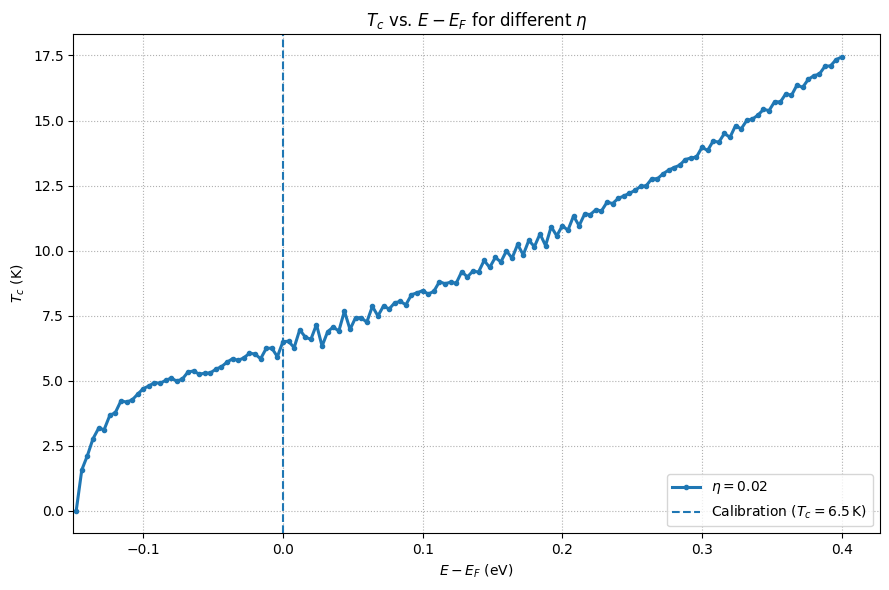

In [13]:
# -*- coding: utf-8 -*-
# 说明: 横坐标改为 E - E_F，并仅从 -0.15 eV 起绘图

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------------ Find Tc ----------------------------
# Find Tc at given H=0 using bisection method searching in [Tmin, Tmax]
def find_Tc(V, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw, Tmax=20.0, Tmin=0.01):
    # Check if it's superconducting at all (at T_min) — H=0.0
    chi_minT = chi_singlet_vectorized(Tmin, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
    if V * chi_minT < 1.0:
        return 0.0  # Not superconducting

    # Check if it's normal at Tmax — H=0.0
    chi_maxT = chi_singlet_vectorized(Tmax, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
    if V * chi_maxT > 1.0:
        print(f"Warning: Still superconducting at Tmax={Tmax}K for EF={EF}. Increase Tmax.")
        return Tmax

    lo, hi = Tmin, Tmax
    for _ in range(24):  # Bisection search
        mid = 0.5 * (lo + hi)
        v = V * chi_singlet_vectorized(mid, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
        if v >= 1.0:  # superconducting (T < Tc)
            lo = mid
        else:         # normal (T > Tc)
            hi = mid
    return 0.5 * (lo + hi)

# ------------------------ Calculate Tc(mu) for fixed V ------------------------
print("Calibrating fixed V...")
target_meV_for_V = 13.0
beta_for_V = beta_from_target(target_meV_for_V)

gz_fun_fixed = lambda kx, ky, fK=fK, b=beta_for_V: gzz(kx, ky, fK, b)
gR_fun_fixed = lambda kx, ky, fK=fK, b=beta_for_V: gR_vec(kx, ky, fK, b)

Tc_initial = 6.5       # K
Nw = 1600              # Matsubara frequencies
n_keep_value = 5000    # FS sample size per valley
FSrad = 0.5            # FS patch radius
Nk_value = 251

# Zeeman-type coupling fixed
alpha_Z_fixed = alpha

# FS shell at original E_F for V calibration
kK_initial, kKm_initial = build_FS_shell(mu_guess, E_F, FSrad, Nk_value, n_keep_value)
print(f"FS sample per valley (for V calibration): {kK_initial[0].size}")

# EF scan setup
EF_center = E_F
EF_scan_range = 0.4      # eV
N_mu_points = 201
EF_range = np.linspace(EF_center - EF_scan_range, EF_center + EF_scan_range, N_mu_points)
dE_range = EF_range - EF_center  # 横坐标: E - E_F

# 仅从该位置开始绘图
x_min = -0.15
mask_global = dE_range >= x_min

# eta values
# eta_list = [0.02, 0.1, 0.3, 0.5]
eta_list = [0.02]

print(f"Building FS shell at calibration point EF_center = {EF_center:.4f} eV")
kK_calib, kKm_calib = build_FS_shell(mu_guess, E_F, FSrad, Nk_value, n_keep_value)
print(f"FS sample per valley (for V calibration): {kK_calib[0].size}")

# Plot
plt.figure(figsize=(9, 6))
print(f"Starting Tc(E - E_F) calculation for eta list: {eta_list}")

for eta in eta_list:
    print(f"\n--- Processing eta = {eta:.2f} ---")

    # Rashba coupling for this eta
    alpha_R_current = eta * alpha_Z_fixed

    # Calibrate V at EF_center to satisfy Tc(EF_center) = Tc_initial for this eta
    V_calibrated = determine_V(Tc_initial, alpha_Z_fixed, alpha_R_current,
                               gz_fun_fixed, gR_fun_fixed,
                               kK_calib, mu_guess, EF_center, Nw)
    print(f"  Calibrated V = {V_calibrated:.6f} for eta = {eta:.2f}")

    Tc_results_for_this_eta = []

    # Scan EF_range; 计算用全范围，绘图再截取
    desc = f"  Scanning E (eta={eta:.2f})"
    for EF_val in tqdm(EF_range, desc=desc):
        # Rebuild FS shell for current EF_val
        kK_new, kKm_new = build_FS_shell(mu_guess, EF_val, FSrad, Nk_value, n_keep_value)

        # Find Tc using calibrated V
        Tc_new = find_Tc(V_calibrated, alpha_Z_fixed, alpha_R_current,
                         gz_fun_fixed, gR_fun_fixed,
                         kK_new, mu_guess, EF_val, Nw, Tmax=20.0)
        Tc_results_for_this_eta.append(Tc_new)

    # 截取从 x_min 开始的部分
    dE_plot = dE_range[mask_global]
    Tc_plot = np.array(Tc_results_for_this_eta)[mask_global]

    # 绘图
    plt.plot(dE_plot, Tc_plot, lw=2.2,
             marker='o', markersize=3,
             label=rf'$\eta={eta:.2f}$')

# Finalize
plt.xlabel(r'$E - E_F$ (eV)')
plt.ylabel(r'$T_c$ (K)')
plt.title(r'$T_c$ vs. $E - E_F$ for different $\eta$')
plt.axvline(0.0, ls='--', label=f'Calibration ($T_c={Tc_initial}\\,$K)')
plt.xlim(left=x_min)
plt.grid(True, ls=':')
plt.legend()
plt.tight_layout()
plt.show()


### Find $V(\mu)$ for fix $T_c$ and magnetic field = 0

<>:72: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
<>:72: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
/var/folders/qy/lhsl8hcx2ldg1vwqx857ty000000gn/T/ipykernel_64623/2792708515.py:72: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
  plt.axvline(EF_center, color='red', ls='--', label=f'Original $\mu_0$')


Using fixed Tc = 6.5 K
Using fixed SOI g-function shapes for target_meV = 13.0
Scanning mu (E_F) from -0.948 eV to -0.548 eV

--- Processing eta = 0.02 ---


  Scanning V(mu) (eta=0.02): 100%|██████████| 51/51 [00:11<00:00,  4.31it/s]



--- Processing eta = 0.10 ---


  Scanning V(mu) (eta=0.10): 100%|██████████| 51/51 [00:11<00:00,  4.54it/s]



--- Processing eta = 0.30 ---


  Scanning V(mu) (eta=0.30): 100%|██████████| 51/51 [00:11<00:00,  4.53it/s]



--- Processing eta = 0.50 ---


  Scanning V(mu) (eta=0.50): 100%|██████████| 51/51 [00:11<00:00,  4.55it/s]


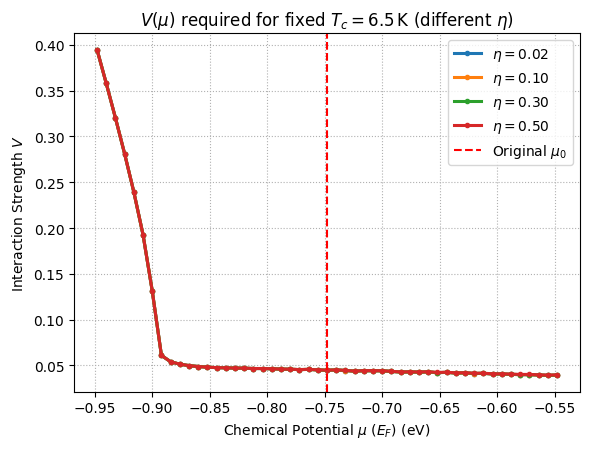

In [ ]:
# ------------------------ Calculate V(mu) for fixed Tc ------------------------

# Set fixed parameters
Tc_fixed_K = 6.5  # Fixed Critical Temperature
Nw = 2000          # Matsubara frequencies
n_keep_value = 5000    # FS sample size per valley
FSrad = 0.4       # FS patch radius
Nk_value=201

# Set fixed SOI parameters (using the 13 meV case from the paper)
target_meV_fixed = 13.0
beta_fixed = beta_from_target(target_meV_fixed)

# Define the g-functions with this fixed beta
gz_fun_fixed = lambda kx, ky, fK=fK, b=beta_fixed: gzz(kx, ky, fK, b)
gR_fun_fixed = lambda kx, ky, fK=fK, b=beta_fixed: gR_vec(kx, ky, fK, b)

# The Zeeman-type coupling strength is fixed
alpha_Z_fixed = alpha

print(f"Using fixed Tc = {Tc_fixed_K} K")
print(f"Using fixed SOI g-function shapes for target_meV = {target_meV_fixed}")

# Define range of chemical potential (mu, i.e., E_F) to scan
# This is the original E_F = E_K_raw + 0.15
EF_center = E_F 
EF_scan_range = 0.2   # Scan range in eV
N_mu_points = 51      # Number of points in the scan
EF_range = np.linspace(EF_center - EF_scan_range, EF_center + EF_scan_range, N_mu_points)
print(f"Scanning mu (E_F) from {EF_range[0]:.3f} eV to {EF_range[-1]:.3f} eV")

# Define eta list and initialize plot
#eta_list = [0.00, 0.02, 0.06, 0.10]
eta_list = [0.02, 0.1, 0.3, 0.5]

plt.figure(figsize=(6, 4.6))

# Loop over eta, and for each, scan V(mu)
for eta in eta_list:
    print(f"\n--- Processing eta = {eta:.2f} ---")
    
    # Set the Rashba coupling for this eta
    alpha_R_current = eta * alpha_Z_fixed
    
    V_results_for_this_eta = []
    
    # Scan over the E_F range
    desc = f"  Scanning V(mu) (eta={eta:.2f})"
    for EF_val in tqdm(EF_range, desc=desc):
        
        # Re-build FS shell for this E_F value
        kK_new, kKm_new = build_FS_shell(mu_guess, EF_val, FSrad, Nk_value,n_keep_value)
        
        # Calculate V needed for Tc=6.5K at this EF_val and eta
        # (This call uses the correct signature for determine_V)
        V_new = determine_V(Tc_fixed_K, alpha_Z_fixed, alpha_R_current,
                            gz_fun_fixed, gR_fun_fixed,
                            kK_new, mu_guess, EF_val, Nw)
        
        V_results_for_this_eta.append(V_new)

    # Plot this eta's curve
    plt.plot(EF_range, V_results_for_this_eta, lw=2.2, 
             marker='o', markersize=3, 
             label=rf'$\eta={eta:.2f}$')

# Finalize and show the plot
plt.xlabel(r'Chemical Potential $\mu$ ($E_F$) (eV)')
plt.ylabel(r'Interaction Strength $V$')
plt.title(r'$V(\mu)$ required for fixed $T_c = 6.5\,$K (different $\eta$)')
# Add a vertical line at the original E_F
plt.axvline(EF_center, color='red', ls='--', label=f'Original $\mu_0$')
plt.grid(True, ls=':')
plt.legend()
plt.tight_layout()
plt.show()


### Find $V(\mu)$ for fix $T_c$ and magnetic field = 0 and with E-EF as x axis

Using fixed Tc = 6.5 K
Using fixed SOI g-function shapes for target_meV = 13.0
Scanning mu (E_F) from -1.048 eV to -0.448 eV

--- Processing eta = 0.02 ---


  Scanning V(E - E_F) (eta=0.02): 100%|██████████| 201/201 [1:21:39<00:00, 24.37s/it]


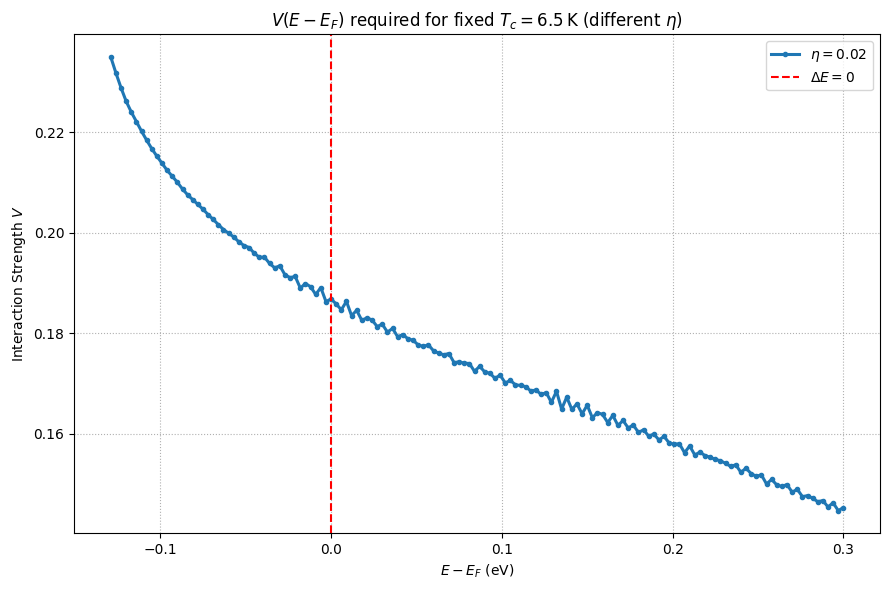

In [11]:
# -*- coding: utf-8 -*-
# 将横坐标由 EF 改为 E - E_F，并仅绘制从 -0.15 eV 开始的部分

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------------ Calculate V(mu) for fixed Tc ------------------------

# 固定参数
Tc_fixed_K = 6.5    # 固定临界温度
Nw = 2000           # Matsubara 频数
n_keep_value = 40000 # 每个 valley 的FS采样点数
FSrad = 0.5         # FS patch 半径
Nk_value = 300

# 固定 SOI 参数 (论文的 13 meV 案例)
target_meV_fixed = 13.0
beta_fixed = beta_from_target(target_meV_fixed)

# 固定的 g 函数
gz_fun_fixed = lambda kx, ky, fK=fK, b=beta_fixed: gzz(kx, ky, fK, b)
gR_fun_fixed = lambda kx, ky, fK=fK, b=beta_fixed: gR_vec(kx, ky, fK, b)

# 固定 Zeeman 型耦合
alpha_Z_fixed = alpha

print(f"Using fixed Tc = {Tc_fixed_K} K")
print(f"Using fixed SOI g-function shapes for target_meV = {target_meV_fixed}")

# 扫描化学势范围（绝对量）
EF_center = E_F
EF_scan_range = 0.3
N_mu_points = 201
EF_range = np.linspace(EF_center - EF_scan_range, EF_center + EF_scan_range, N_mu_points)
dE_range = EF_range - EF_center  # 横坐标: E - E_F
print(f"Scanning mu (E_F) from {EF_range[0]:.3f} eV to {EF_range[-1]:.3f} eV")

# eta 列表
# eta_list = [0.02, 0.1, 0.3, 0.5]
eta_list = [0.02]

plt.figure(figsize=(9, 6))

# 对每个 eta 扫描 V(mu)
for eta in eta_list:
    print(f"\n--- Processing eta = {eta:.2f} ---")

    # 对应的 Rashba 耦合
    alpha_R_current = eta * alpha_Z_fixed

    V_results_for_this_eta = []

    # 扫描 EF_range（计算仍用绝对 EF；绘图使用 dE_range）
    desc = f"  Scanning V(E - E_F) (eta={eta:.2f})"
    for EF_val in tqdm(EF_range, desc=desc):
        # 按当前 EF 重建FS
        kK_new, kKm_new = build_FS_shell(mu_guess, EF_val, FSrad, Nk_value, n_keep_value)

        # 计算在该 EF 下实现 Tc=6.5K 所需的 V
        V_new = determine_V(Tc_fixed_K, alpha_Z_fixed, alpha_R_current,
                            gz_fun_fixed, gR_fun_fixed,
                            kK_new, mu_guess, EF_val, Nw)
        V_results_for_this_eta.append(V_new)

    # 截取从 E - E_F >= -0.15 开始的部分
    mask = dE_range >= -0.13
    dE_plot = dE_range[mask]
    V_plot = np.array(V_results_for_this_eta)[mask]

    # 绘图
    plt.plot(dE_plot, V_plot, lw=2.2,
             marker='o', markersize=3,
             label=rf'$\eta={eta:.2f}$')

# 收尾
plt.xlabel(r'$E - E_F$ (eV)')
plt.ylabel(r'Interaction Strength $V$')
plt.title(r'$V(E - E_F)$ required for fixed $T_c = 6.5\,$K (different $\eta$)')
plt.axvline(0.0, color='red', ls='--', label=r'$\Delta E = 0$')
plt.grid(True, ls=':')
plt.legend()
plt.tight_layout()
plt.show()


### DOS

Starting calibration...
Set Fermi Level E_F = -0.7479 eV
Calibrated alpha_Z = 0.000577
Calibrated beta = 27.2330
Calibrated alpha_R = 0.000012 (using eta=0.02)
--- Calibration Complete ---
Generated a 201x201 grid (40401 total k-points).
Calculating energies for all k-points... (this may take a moment)
...Energy calculation complete.
Sorting all energies...
...Sorting complete.
Functions N_per_cell(E) and DOS_per_cell() are now defined.


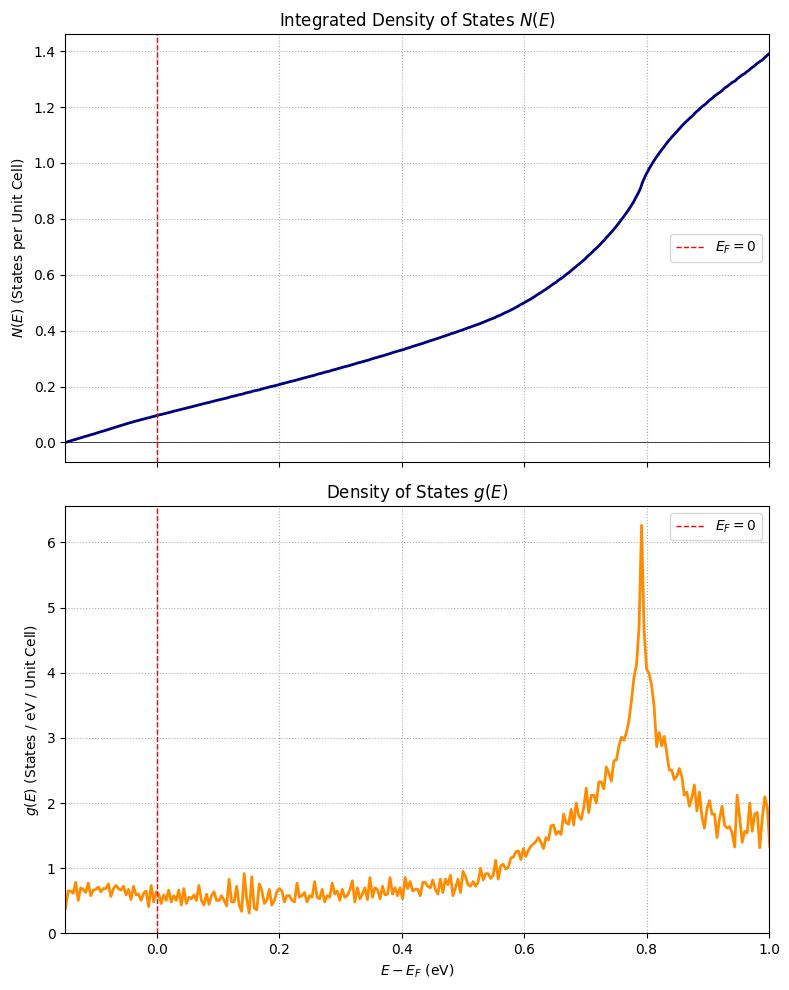


N(E=0) = 0.0963 (states per cell below E_F)


In [5]:

# (Assuming all required helper functions like eps_Mo, gzz, gR_mag, f_k, core_g,
# path_around_K, and constants like K, M, a, t1, t2, t3 are defined above)

# --- 1. Re-run Calibration (using logic from your previous scripts) ---
print("Starting calibration...")

# a) Calibrate E_F
mu_guess = 0.0
E_K_raw = eps_Mo(K[0], K[1], mu_guess)
E_F = E_K_raw + 0.15
E_kin = lambda kx, ky: eps_Mo(kx, ky, mu_guess) - E_F
print(f"Set Fermi Level E_F = {E_F:.4f} eV")

# b) Calibrate alpha_Z (using 3 meV splitting at K)
fK = f_k(K[0], K[1])
coreK = abs(core_g(K[0], K[1]))
alpha_Z = (3e-3) / (2.0 * max(coreK, 1e-18))
print(f"Calibrated alpha_Z = {alpha_Z:.6f}")

# c) Calibrate beta (using 13 meV splitting at k_F)
try:
    kx_path, ky_path, s_path = path_around_K(0.2, 301)
    mask_R = s_path >= 0
    Ei_path = E_kin(kx_path[mask_R], ky_path[mask_R])
    kF_idx = np.argmin(np.abs(Ei_path))
    kF_kx, kF_ky = kx_path[mask_R][kF_idx], ky_path[mask_R][kF_idx]
    
    betas_calib = np.linspace(0.5, 200.0, 2001)
    spls_calib = np.array([2*alpha_Z*abs(gzz(kF_kx, kF_ky, fK, b)) for b in betas_calib])
    target_meV_kf = 13.0
    beta = float(betas_calib[np.argmin(np.abs(spls_calib - target_meV_kf*1e-3))])
    print(f"Calibrated beta = {beta:.4f}")

except NameError:
    print("Warning: path_around_K function not found. Skipping beta calibration.")
    print("Using beta provided by user (which might be 0).")
    pass


# d) Calibrate alpha_R (Rashba strength)
eta = 0.02
alpha_R = eta * alpha_Z
print(f"Calibrated alpha_R = {alpha_R:.6f} (using eta={eta})")
print("--- Calibration Complete ---")


# --- 2. Generate 2D k-mesh ---
Nk = 201
kx_max = M[0] * 1.2
ky_max = K[1] * 1.1

kx_vals = np.linspace(-kx_max, kx_max, Nk)
ky_vals = np.linspace(-ky_max, ky_max, Nk)
kx_grid, ky_grid = np.meshgrid(kx_vals, ky_vals, indexing='xy')

N_k_total = float(kx_grid.size)
print(f"Generated a {Nk}x{Nk} grid ({N_k_total:.0f} total k-points).")


# --- 3. Calculate All Energies on the Grid ---
print("Calculating energies for all k-points... (this may take a moment)")
E_k_grid = E_kin(kx_grid, ky_grid)
gz_grid = gzz(kx_grid, ky_grid, fK, beta)
gr_grid = gR_mag(kx_grid, ky_grid, fK, beta)
Gabs_grid = np.sqrt((alpha_Z * gz_grid)**2 + (alpha_R * gr_grid)**2)
E_plus_all = E_k_grid + Gabs_grid
E_minus_all = E_k_grid - Gabs_grid
all_energies = np.concatenate([E_plus_all.flatten(), E_minus_all.flatten()])
print("...Energy calculation complete.")


# --- 4. Sort All Energies ---
print("Sorting all energies...")
all_energies_sorted = np.sort(all_energies)
print("...Sorting complete.")


# --- 5. Define N(E) and g(E) (DOS) Functions ---

def N_per_cell(E):
    count = np.searchsorted(all_energies_sorted, E, side='right')
    return count / N_k_total

def DOS_per_cell(num_bins=200):
    hist, bin_edges = np.histogram(
        all_energies, 
        bins=num_bins, 
        density=False
    )
    
    E_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    
    # Handle potential empty bins or non-constant bin width (though linspace makes it constant)
    dE = bin_edges[1:] - bin_edges[:-1]
    # Avoid division by zero if dE is 0, although unlikely with np.histogram
    dE[dE == 0] = 1.0 
    
    g_E = (hist / N_k_total) / dE
    
    return E_centers, g_E

print("Functions N_per_cell(E) and DOS_per_cell() are now defined.")


# --- 6. Example Usage and Plotting (MODIFIED) ---

# a) Define the *fixed* energy range you want to plot
E_min_fixed = -0.15
E_max_fixed = 1
    
# Create the energy points for the N(E) plot
E_range = np.linspace(E_min_fixed, E_max_fixed, 500)

# b) Calculate N(E) over this specific range
N_E_vals = np.array([N_per_cell(E) for E in E_range])

# c) Calculate g(E) (DOS)
# We calculate the histogram over the *full* energy range
# but will zoom the plot later.
# Increased bins for better resolution over the wide range.
E_dos, g_E_dos = DOS_per_cell(num_bins=400) 

# d) Create plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Plot N(E)
ax1.plot(E_range, N_E_vals, lw=2, color='navy')
ax1.set_ylabel(r'$N(E)$ (States per Unit Cell)')
ax1.set_title('Integrated Density of States $N(E)$')
ax1.grid(True, ls=':')
ax1.axhline(0, color='k', lw=0.5)
ax1.axvline(0, color='r', ls='--', lw=1, label='$E_F = 0$')
ax1.legend()
# **** MODIFICATION: Set fixed X-axis limit for N(E) plot ****
ax1.set_xlim(E_min_fixed, E_max_fixed)

# Plot g(E)
ax2.plot(E_dos, g_E_dos, lw=2, color='darkorange')
ax2.set_xlabel(r'$E - E_F$ (eV)')
ax2.set_ylabel(r'$g(E)$ (States / eV / Unit Cell)')
ax2.set_title('Density of States $g(E)$')
ax2.grid(True, ls=':')
ax2.set_ylim(bottom=0)
ax2.axvline(0, color='r', ls='--', lw=1, label='$E_F = 0$')
ax2.legend()
# **** MODIFICATION: Set fixed X-axis limit for g(E) plot ****
ax2.set_xlim(E_min_fixed, E_max_fixed)

plt.tight_layout()
plt.show()

# Example: Find N(0), the number of states below E_F
N_at_EF = N_per_cell(0.0)
print(f"\nN(E=0) = {N_at_EF:.4f} (states per cell below E_F)")

### BCS theory limitation

开始扫描 mu，计算 Tc(μ)、H_P^BCS(μ)、H_P^num(μ)...


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


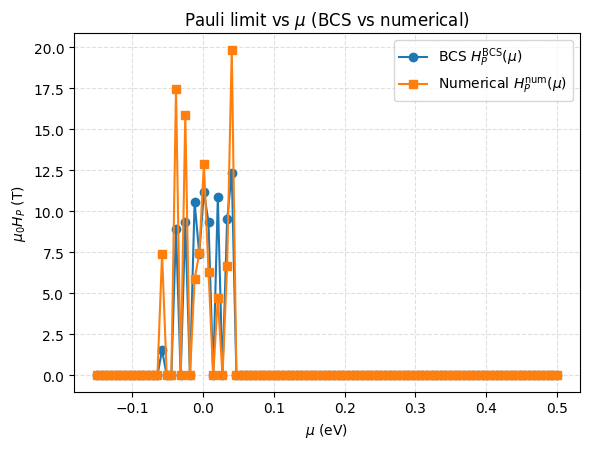

In [ ]:

# ------------------------ Find Tc ----------------------------
# H = 0 时，用二分法在 [Tmin, Tmax] 内寻找 Tc
def find_Tc(V, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw,
            Tmax=20.0, Tmin=0.01):
    # Tmin 时先判断是否超导
    chi_minT = chi_singlet_vectorized(Tmin, 0.0, alpha_Z, alpha_R,
                                      gz_func, gR_func, kK,
                                      mu_guess, EF, Nw)
    if V * chi_minT < 1.0:
        return 0.0  # 不超导

    # Tmax 时检查是否已经变成正常态
    chi_maxT = chi_singlet_vectorized(Tmax, 0.0, alpha_Z, alpha_R,
                                      gz_func, gR_func, kK,
                                      mu_guess, EF, Nw)
    if V * chi_maxT > 1.0:
        print(f"Warning: Still superconducting at Tmax={Tmax}K for EF={EF}. Increase Tmax.")
        return Tmax

    lo, hi = Tmin, Tmax
    for _ in range(24):  # 二分
        mid = 0.5 * (lo + hi)
        v = V * chi_singlet_vectorized(mid, 0.0, alpha_Z, alpha_R,
                                       gz_func, gR_func, kK,
                                       mu_guess, EF, Nw)
        if v >= 1.0:   # 仍超导 (T < Tc)
            lo = mid
        else:          # 正常态 (T > Tc)
            hi = mid
    return 0.5 * (lo + hi)


# ------------------------ 数值 Pauli limit ----------------------------
def find_Hp_numeric_single_EF(EF_val,
                              V,
                              alpha_Z,
                              alpha_R,
                              gz_func,
                              gR_func,
                              kK,
                              mu_guess,
                              Nw,
                              T0=0.01,
                              Hp_BCS_hint=None,
                              H_max_factor=4.0,
                              tol=1e-3,
                              max_iter=60):
    """
    对固定的 EF_val 数值求解 Pauli limit:
      解 f(H) = V * chi_singlet(T~0, H, mu_guess, EF_val) - 1 = 0
    用 BCS Pauli limit 做搜索区间参考, 提高稳定性.
    """

    # 没有 BCS 参考或 Tc<=0 时，直接认为没有 Pauli limit
    if Hp_BCS_hint is None or Hp_BCS_hint <= 0.0:
        return 0.0

    def f(H):
        chi = chi_singlet_vectorized(T0, H, alpha_Z, alpha_R,
                                     gz_func, gR_func, kK,
                                     mu_guess, EF_val, Nw)
        return V * chi - 1.0

    # 先看 H=0 是否超导
    f0 = f(0.0)
    if f0 <= 0.0:
        return 0.0

    # 以 BCS Pauli limit 为上界的几倍来找翻号区间
    H_low = 0.0
    H_high = H_max_factor * Hp_BCS_hint
    f_high = f(H_high)

    expand_count = 0
    while f_high > 0.0 and expand_count < 5:
        H_high *= 1.5
        f_high = f(H_high)
        expand_count += 1

    # 仍未翻号：认为数值 Pauli limit 很大或不存在，这里保守记为 0
    if f_high > 0.0:
        return 0.0

    # 二分法
    for _ in range(max_iter):
        H_mid = 0.5 * (H_low + H_high)
        f_mid = f(H_mid)

        if abs(H_high - H_low) < tol:
            return H_mid

        if f_mid > 0.0:
            H_low = H_mid
        else:
            H_high = H_mid

    return 0.5 * (H_low + H_high)


# ------------------------ 全局参数 ----------------------------
print("Calibrating fixed V...")

target_meV_for_V = 13.0
beta_for_V = beta_from_target(target_meV_for_V)

gz_fun_fixed = lambda kx, ky, fK=fK, b=beta_for_V: gzz(kx, ky, fK, b)
gR_fun_fixed = lambda kx, ky, fK=fK, b=beta_for_V: gR_vec(kx, ky, fK, b)

Tc_initial = 6.5       # K, 在 EF_center 处校准的 Tc
Nw = 1600              # Matsubara 频数
n_keep_value = 5000    # 每个 valley 的 FS 采样点
FSrad = 0.5            # FS patch 半径
Nk_value = 251

alpha_Z_fixed = alpha   # Zeeman-type 耦合

# ------- EF 扫描设置 (横轴: E - E_F) -------
EF_center = E_F
EF_scan_range = 0.4      # eV
N_E_points = 51
EF_range = np.linspace(EF_center - EF_scan_range,
                       EF_center + EF_scan_range,
                       N_E_points)
dE_range = EF_range - EF_center

# 只从某个 E - E_F 起画图
x_min = -0.15
mask_global = dE_range >= x_min

# eta = alpha_R / alpha_Z
eta_list = [0.02, 0.1, 0.3, 0.5]

print(f"Building FS shell at calibration point EF_center = {EF_center:.4f} eV")
kK_calib, kKm_calib = build_FS_shell(mu_guess, E_F,
                                     FSrad, Nk_value, n_keep_value)
print(f"FS sample per valley (for V calibration): {kK_calib[0].size}")

print(f"Starting Tc(E - E_F) & Pauli limit calculation for eta list: {eta_list}")

# 准备两幅图
fig_Tc, ax_Tc = plt.subplots(figsize=(9, 6))
fig_Hp, ax_Hp = plt.subplots(figsize=(9, 6))

for eta in eta_list:
    print(f"\n--- Processing eta = {eta:.2f} ---")

    alpha_R_current = eta * alpha_Z_fixed

    # 在 EF_center 处用 Tc_initial 校准 V
    V_calibrated = determine_V(Tc_initial, alpha_Z_fixed, alpha_R_current,
                               gz_fun_fixed, gR_fun_fixed,
                               kK_calib, mu_guess, EF_center, Nw)
    print(f"  Calibrated V = {V_calibrated:.6f} for eta = {eta:.2f}")

    Tc_results        = []
    Hp_BCS_results    = []
    Hp_num_results    = []

    desc = f"  Scanning E (eta={eta:.2f})"
    for EF_val in tqdm(EF_range, desc=desc):
        # 1) 当前 EF 的 FS shell
        kK_new, kKm_new = build_FS_shell(mu_guess, EF_val,
                                         FSrad, Nk_value, n_keep_value)

        # 2) Tc(EF_val)
        Tc_new = find_Tc(V_calibrated, alpha_Z_fixed, alpha_R_current,
                         gz_fun_fixed, gR_fun_fixed,
                         kK_new, mu_guess, EF_val, Nw, Tmax=20.0)

        Tc_results.append(Tc_new)

        # 3) BCS Pauli limit
        if Tc_new > 0.0:
            Hp_BCS_new = 1.86 * Tc_new
        else:
            Hp_BCS_new = 0.0
        Hp_BCS_results.append(Hp_BCS_new)

        # 4) 数值 Pauli limit (只在 Tc>0 时求)
        if Tc_new > 0.0:
            Hp_num_new = find_Hp_numeric_single_EF(
                EF_val,
                V_calibrated,
                alpha_Z_fixed,
                alpha_R_current,
                gz_fun_fixed,
                gR_fun_fixed,
                kK_new,
                mu_guess,
                Nw,
                T0=0.01,
                Hp_BCS_hint=Hp_BCS_new
            )
        else:
            Hp_num_new = 0.0
        Hp_num_results.append(Hp_num_new)

    # 截取从 x_min 起的部分
    dE_plot      = dE_range[mask_global]
    Tc_plot      = np.array(Tc_results)[mask_global]
    Hp_BCS_plot  = np.array(Hp_BCS_results)[mask_global]
    Hp_num_plot  = np.array(Hp_num_results)[mask_global]

    # --- 画 Tc(E - E_F) ---
    ax_Tc.plot(dE_plot, Tc_plot,
               lw=2.0, marker='o', markersize=3,
               label=rf'$T_c,\,\eta={eta:.2f}$')

    # --- 画 Pauli limit(E - E_F) ---
    ax_Hp.plot(dE_plot, Hp_BCS_plot,
               '-o', markersize=3,
               label=rf'BCS $H_P$, $\eta={eta:.2f}$')
    ax_Hp.plot(dE_plot, Hp_num_plot,
               '-s', markersize=3,
               label=rf'Num $H_P$, $\eta={eta:.2f}$')

# ------------------------ 整理两幅图 ----------------------------
# 图 1: Tc vs E-E_F
ax_Tc.set_xlabel(r'$E - E_F$ (eV)')
ax_Tc.set_ylabel(r'$T_c$ (K)')
ax_Tc.set_title(r'$T_c$ vs. $E - E_F$ for different $\eta$')
ax_Tc.axvline(0.0, ls='--', label=f'Calibration ($T_c={Tc_initial}\\,$K)')
ax_Tc.set_xlim(left=x_min)
ax_Tc.grid(True, ls=':')
ax_Tc.legend()
fig_Tc.tight_layout()

# 图 2: Pauli limit vs E-E_F
ax_Hp.set_xlabel(r'$E - E_F$ (eV)')
ax_Hp.set_ylabel(r'$\mu_0 H_P$ (T)')
ax_Hp.set_title(r'Pauli limit vs. $E - E_F$ (BCS vs numerical)')
ax_Hp.axvline(0.0, ls='--')
ax_Hp.set_xlim(left=x_min)
ax_Hp.grid(True, ls=':')
ax_Hp.legend()
fig_Hp.tight_layout()

plt.show()